# Research Methodology (Week 8)

In [67]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings

# Experimental Algorithm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Gradient extreme gradient boosted trees
from xgboost import XGBRegressor

In [18]:
warnings.filterwarnings('ignore')
sns.set_theme()

<br/>

<br/>

<br/>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem;">
    <h1 style="margin: 0; color: #343d52">Model Building</h1>
</div>

In [108]:
training_df = pd.read_csv("training_set.csv")
training_df.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,SampenCD_2DS,Katz_DeltaDS,Katz_cD_1DS,Katz_cA_4DS,Permen_cD_1DS,Permen_cD_3DS,Permen_GammaDS,Hig_cA_4DS
0,95.8,1.118584,1.589795,2.579210,3.842405,0.295259,0.376660,2.220077,2.975620,0.308904,0.176011,1.891554,1.815630,1.847512,0.997721,0.992431,0.993749,1.812455
1,95.8,1.108791,1.578562,2.427762,3.855503,0.317506,0.404385,2.231705,2.945514,0.319252,0.182602,1.886988,1.818783,1.855281,0.997555,0.993881,0.993224,1.812594
2,95.8,1.111692,1.567324,2.581948,3.533784,0.342623,0.442947,2.239327,2.975240,0.328542,0.187470,1.888266,1.821905,1.858956,0.997616,0.994908,0.992231,1.810743
3,95.6,1.122940,1.594337,2.260806,3.837354,0.371085,0.492027,2.246107,2.976338,0.340638,0.192986,1.883636,1.823571,1.862032,0.998204,0.996844,0.991169,1.810351
4,95.6,1.091586,1.622987,2.301977,3.401760,0.403649,0.552274,2.251073,2.993204,0.337477,0.196044,1.882063,1.824643,1.863008,0.998105,0.998060,0.990647,1.808214


<br/>

## Feature Selection

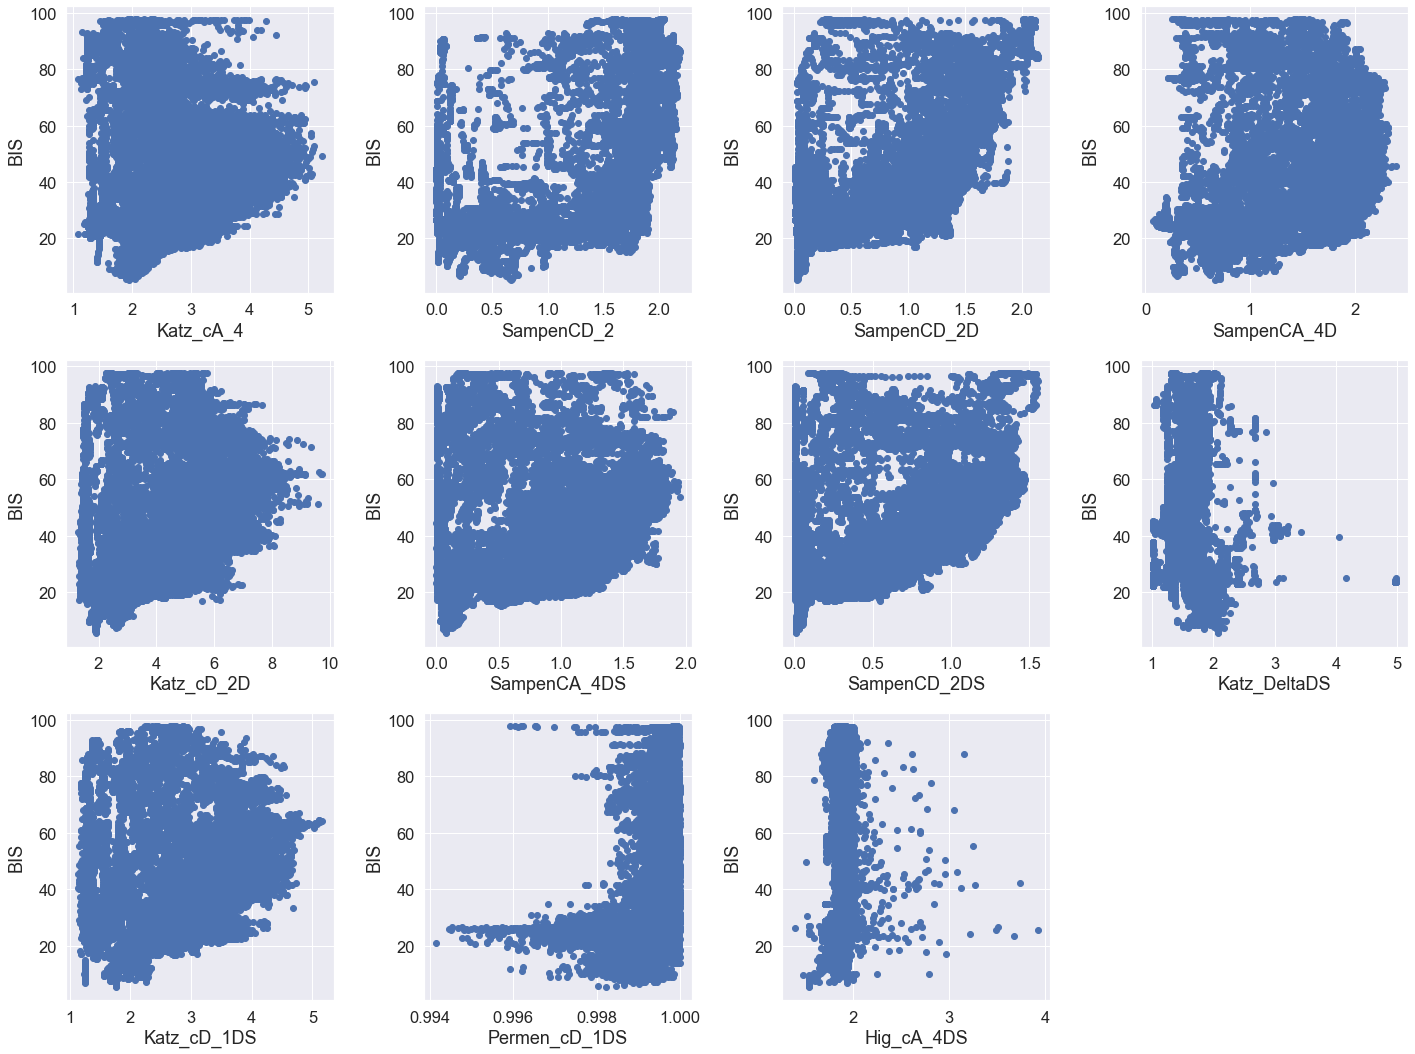

In [23]:
# Selected features
cols = ['Katz_cA_4', 'SampenCD_2', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS']


# Check the relationship between the selected features and the BIS
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax[2, 3].axis('off')

for idx, feature in enumerate(cols[:4]):
    ax[0, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[0, idx].set_ylabel('BIS')
    ax[0, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[4:8]):
    ax[1, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[1, idx].set_ylabel('BIS')
    ax[1, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[8:]):
    ax[2, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[2, idx].set_ylabel('BIS')
    ax[2, idx].set_xlabel(feature)
    
    
plt.tight_layout()
plt.show()

<br/>

## Selected Features

In [166]:
# Removed Hig_cA_4DS, Permen_cD_1DS, Katz_DeltaDS, SampenCD_2
selected_features = ['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_cD_1DS']

print("PRELIMINARY SELECTED FEATURES \n\n{}".format(selected_features))

PRELIMINARY SELECTED FEATURES 

['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_cD_1DS']


<br/>

<br/>

<hr>

# Model Selection and Evaluation

Sebastian discussed how to use *k*-fold cross validation for model selection. So I implemented his ideas. The key idea is keep a separate and independent test set at bay, while we try to model our data with various algorithms. **This is done to avoid the leaking of test data in the training stage**. In addition, I also used GridSearch to find optimum model parameters for each model.

<img src="Model Building.png" />

<p>Model Selection and Evaluation workflow</p>

*Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning* (Sebastian Raschka, 2018)

<br/>

## Model Selection: Part 1

In [139]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale):
        self.model = model
        self.data = data
        self.scale = scale        
            
            
    # Model Selection
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']
        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            
            
        # Ridge regression
        # Param Grid: [{'alpha': param_range}]
        if self.model == 'rr':
            my_model = Ridge()
            my_model.fit(X, y)
            self.my_model = my_model
            
            
            
        # Histogram-based Gradient boosting tree (Experimental)
        # Param Grid: [{max_depth: [100, 110, 120, 130, 140]}]
        if self.model == 'hist_r':
            my_model = HistGradientBoostingRegressor()
            my_model.fit(X, y)
            self.my_model = my_model
            

        
        # Extreme Gradient boosted trees
        # Param Grid: [{'n_estimators': [1000, 1500, 2000], 
        #               'max_depth': [7, 8, 9, 10], 
        #               'gamma': [0, 1, 2, 3, 4, 5]}]
        if self.model == "xgboost":
            my_model = XGBRegressor(n_estimators=100, max_depth=10, gamma=3)
            my_model.fit(X, y)
            self.my_model = my_model
            
            # Feature imporatance
            print("Feature importances: ", my_model.feature_importances_)




        

            
    # Predict for training or test set
    def predict(self, test_data, features, visualize=True, evaluate=True):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']
        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
            
        # Visualize after predicting    
        if visualize == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, label="Actual BIS")
            plt.plot(y_pred, label="Predicted BIS")
            plt.xlabel('Samples')
            plt.ylabel('BIS')
            plt.legend(loc='upper left')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        if evaluate == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.scatter(y_pred, y_pred - y, c='royalblue', marker='o',  edgecolor='white')
            plt.ylabel("Residuals")
            plt.xlabel("Predicted Values")
            plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black', lw=2)
            plt.xlim([xmin, xmax])
            plt.show()
            
            
            # MSE and R^2
            mse = mean_squared_error(y, y_pred)
            
            print("MSE: %.3f" % mse)

                
                
        
            

In [137]:
# Training a linear regression model on the alpha dataset
test_model = model('rr', training_df, scale=False)

test_model.fit(selected_features)

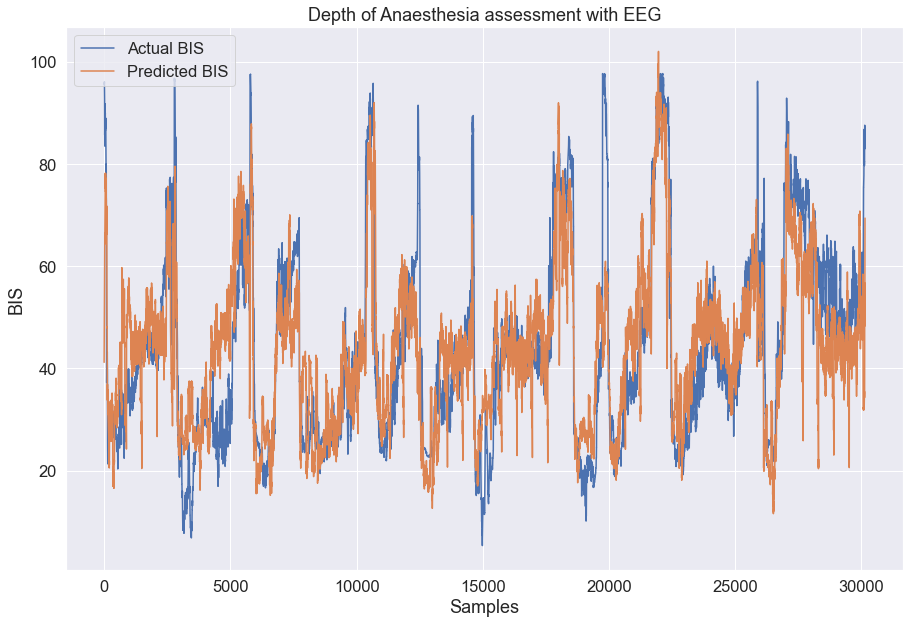

In [138]:
# Testing on the original training set
test_model.predict(training_df, selected_features, evaluate=False)

<br/>

<br/>

In [115]:
# Training set (The patients)
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

<br/>

## <code>Ridge Regression</code>

In [131]:
# Create a linear regression model using the entire training dataset
rr = model('rr', training_df, scale=False)

# Train the model
rr.fit(selected_features)

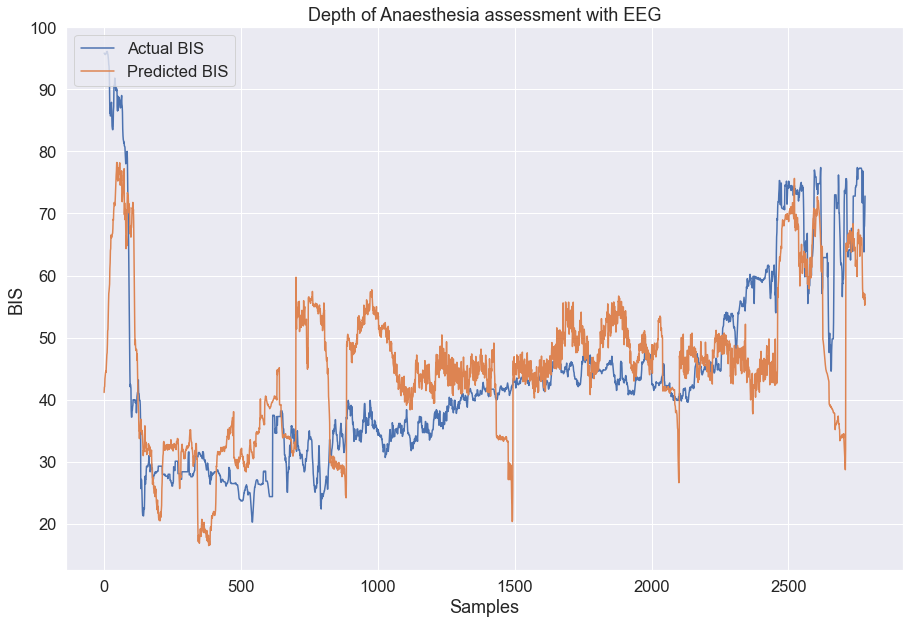

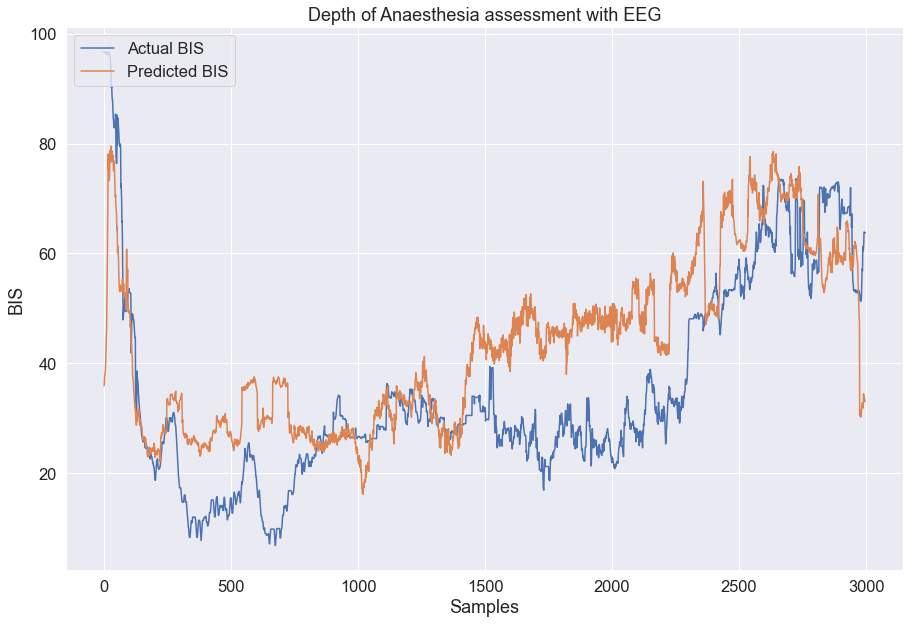

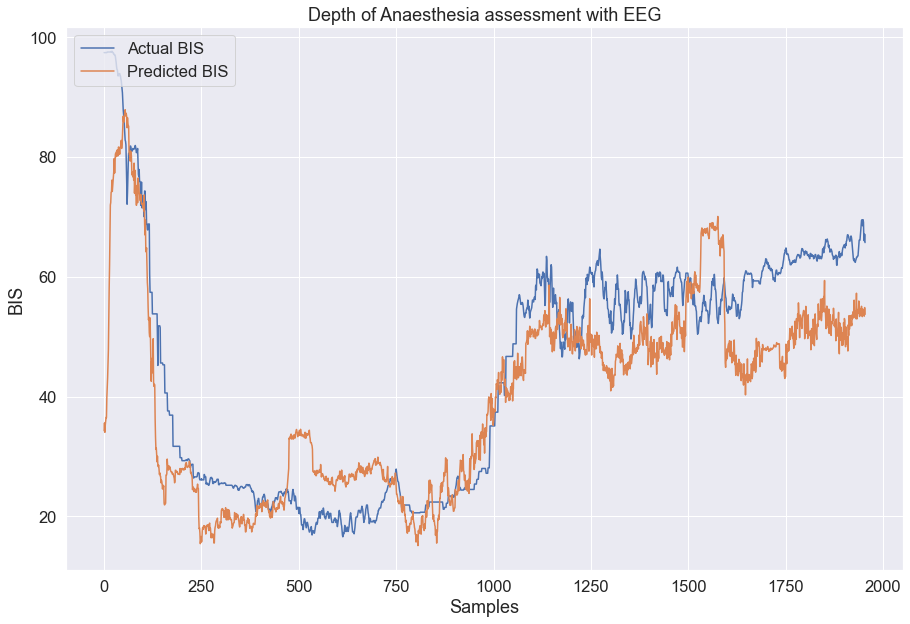

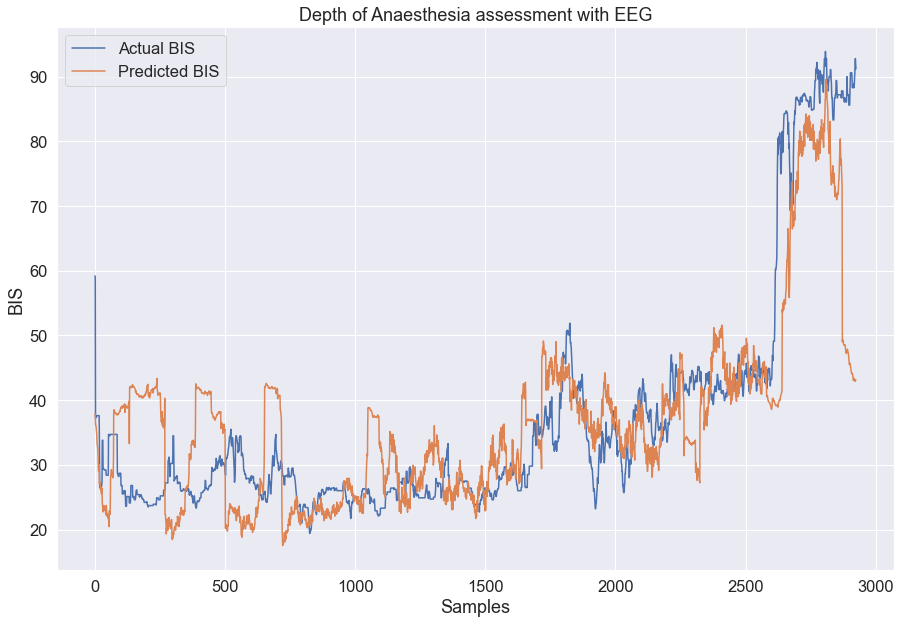

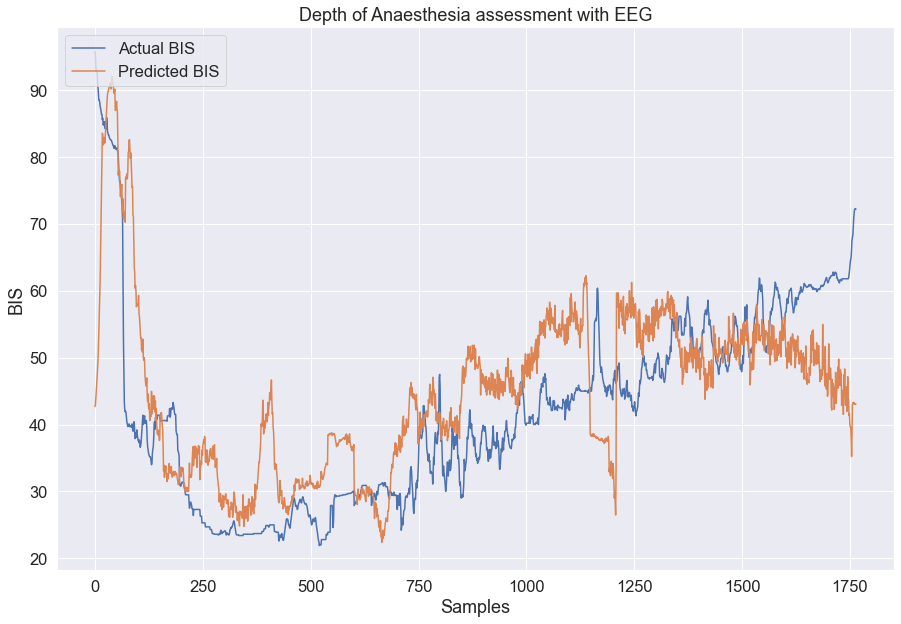

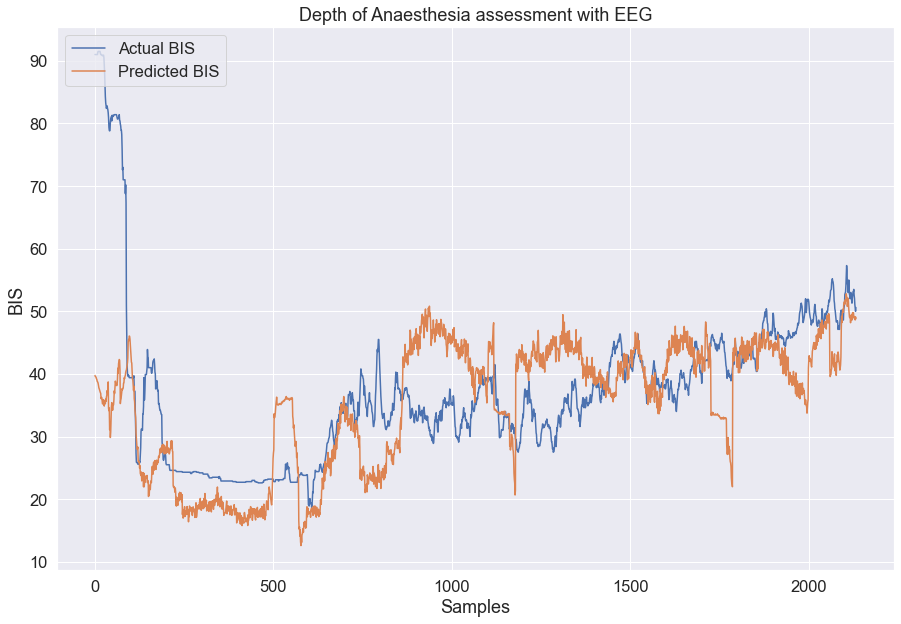

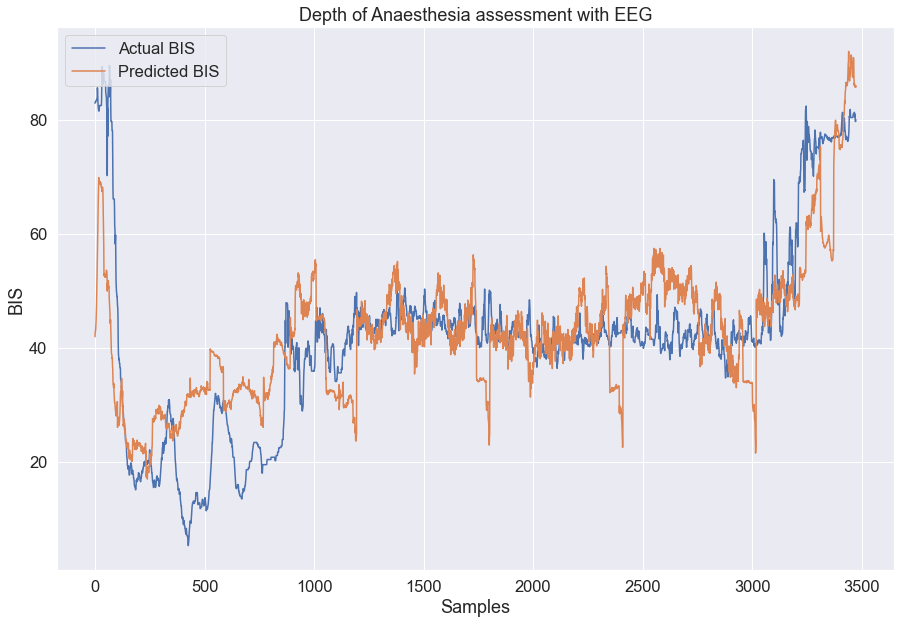

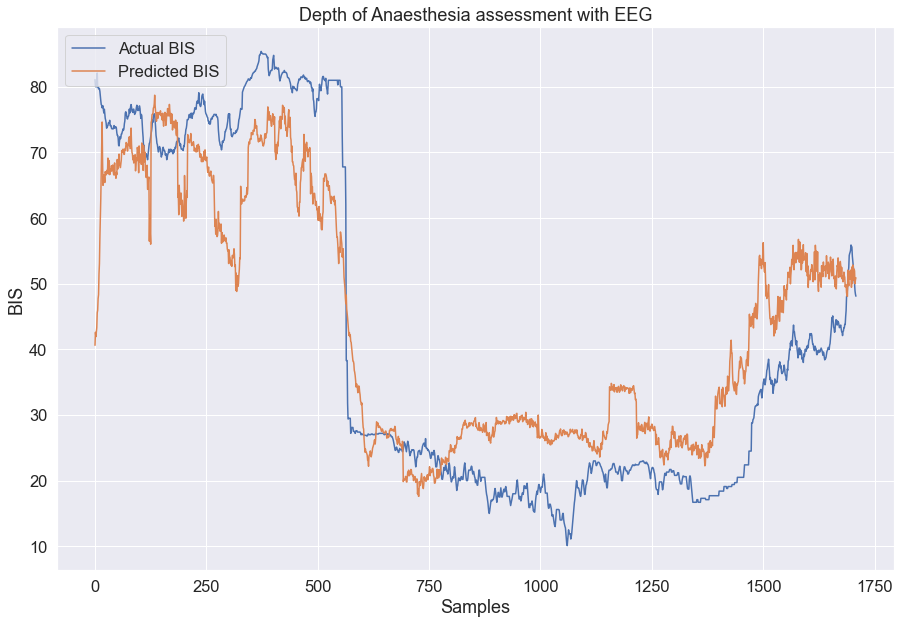

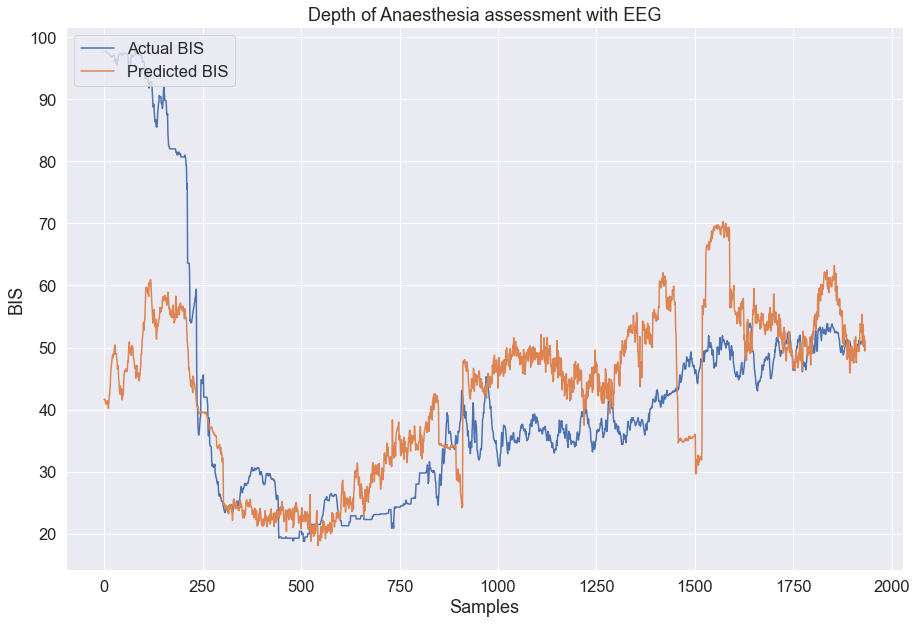

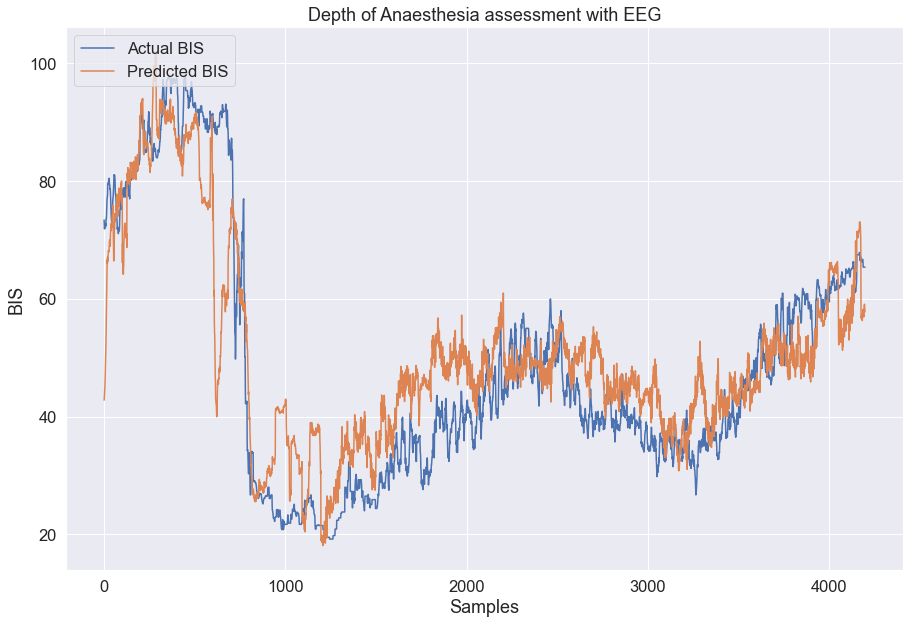

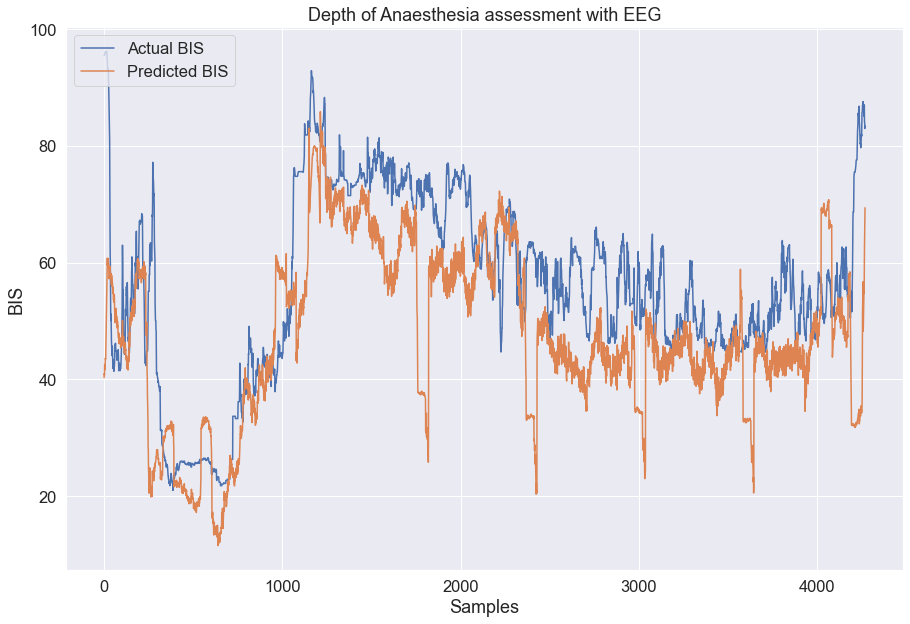

In [132]:
for train in training_set:
    patient = create_dataset(patient=train)
    rr.predict(patient, selected_features, evaluate=False)

<br/>

<br/>

## <code>XG Boost Regression</code>

In [140]:
# Create a linear regression model using the entire training dataset
xg_boost = model('xgboost', training_df, scale=False)

# Train the model
xg_boost.fit(selected_features)

Feature importances:  [0.02841035 0.46845144 0.07191122 0.05892301 0.18404493 0.13213278
 0.05612625]


In [141]:
important_features = ['SampenCD_2D', 'SampenCA_4DS', 'SampenCD_2DS']

('SampenCD_2D', 'SampenCA_4DS', 'SampenCD_2DS')

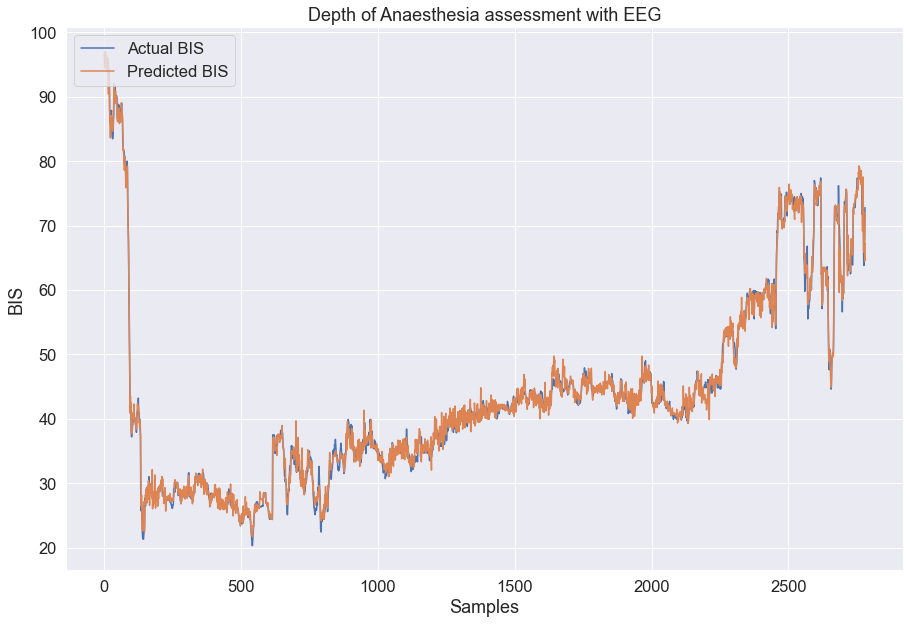

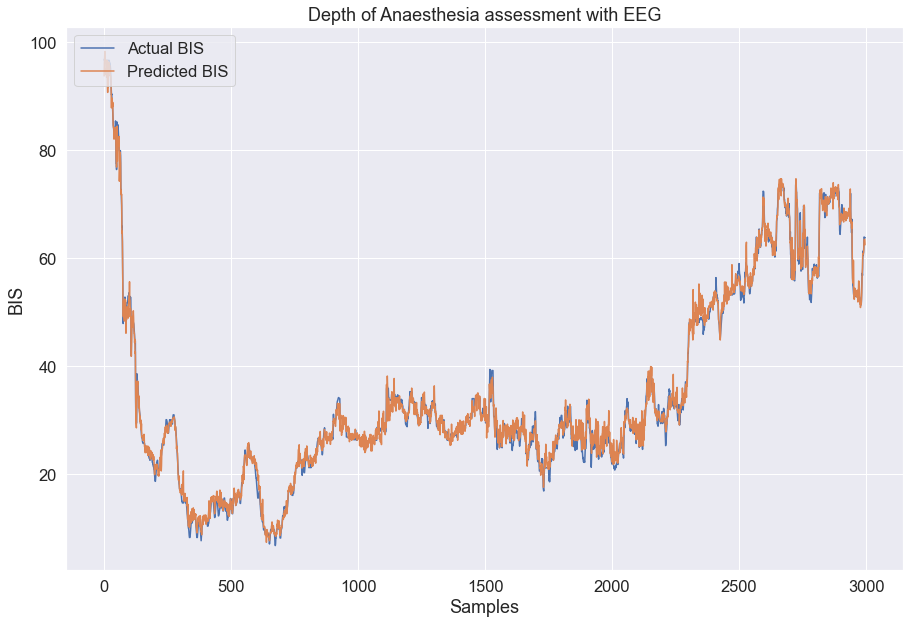

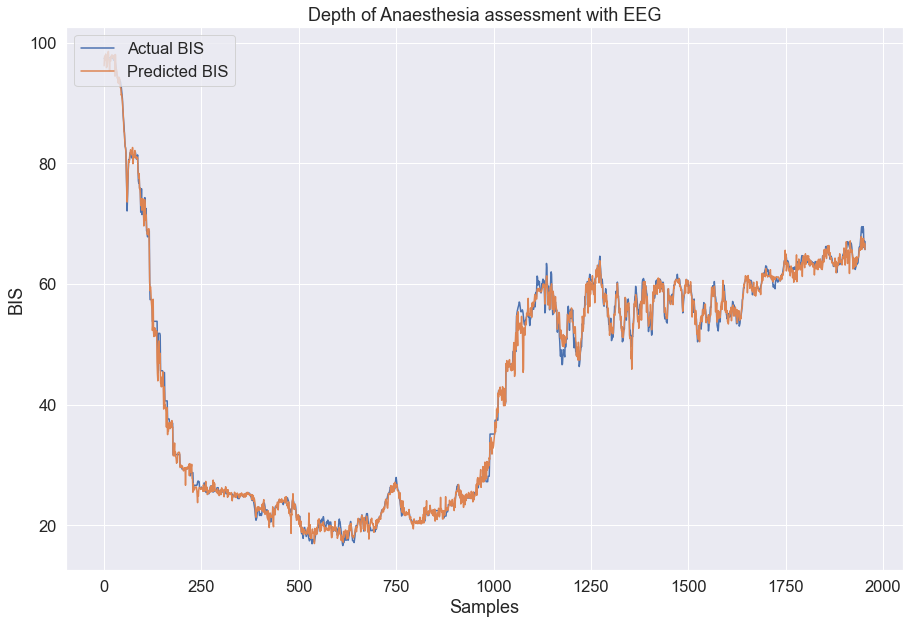

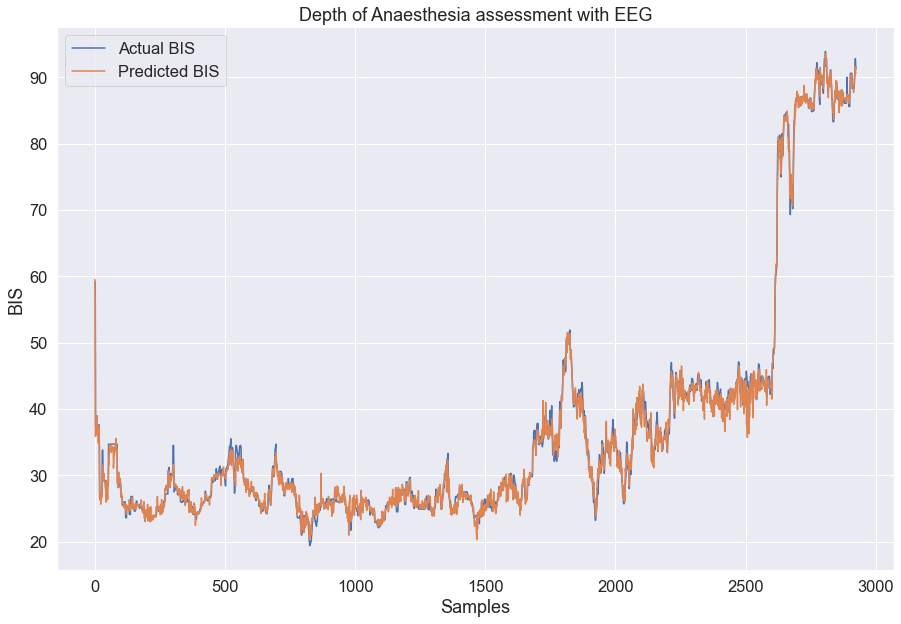

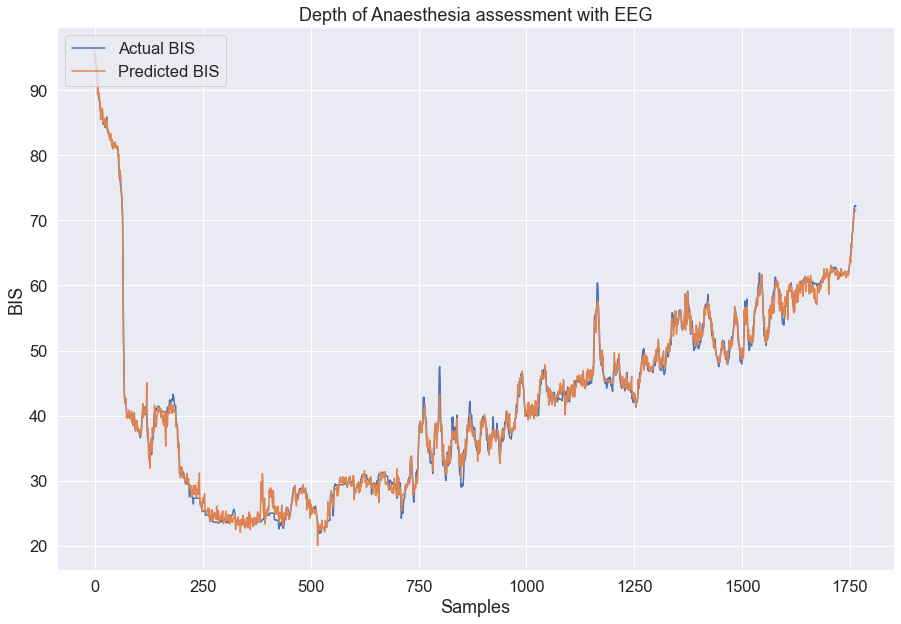

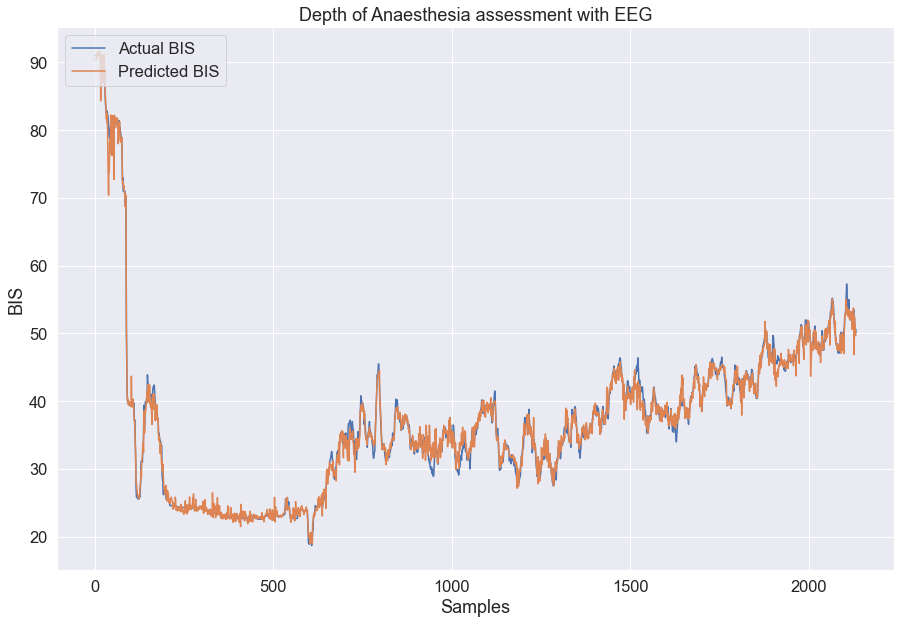

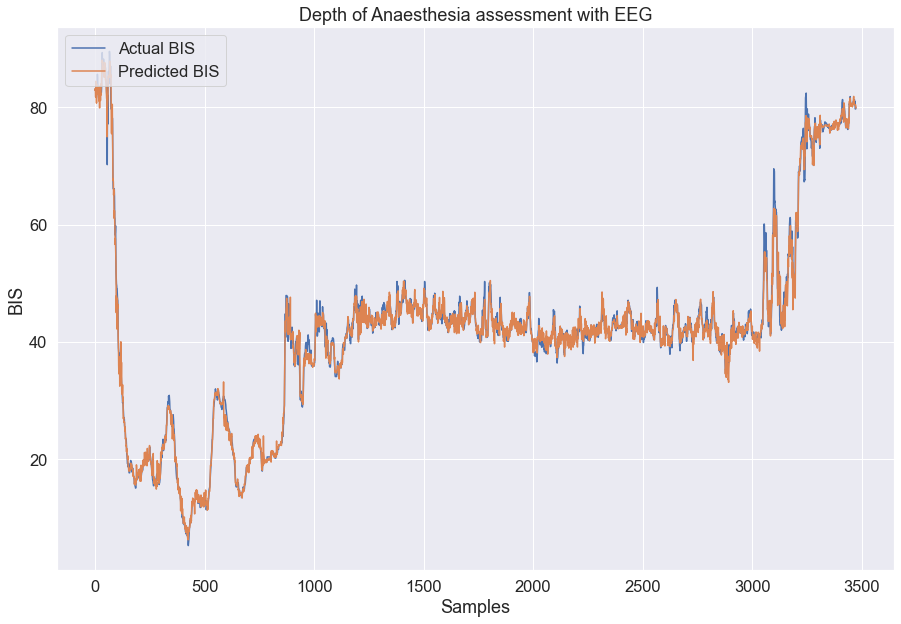

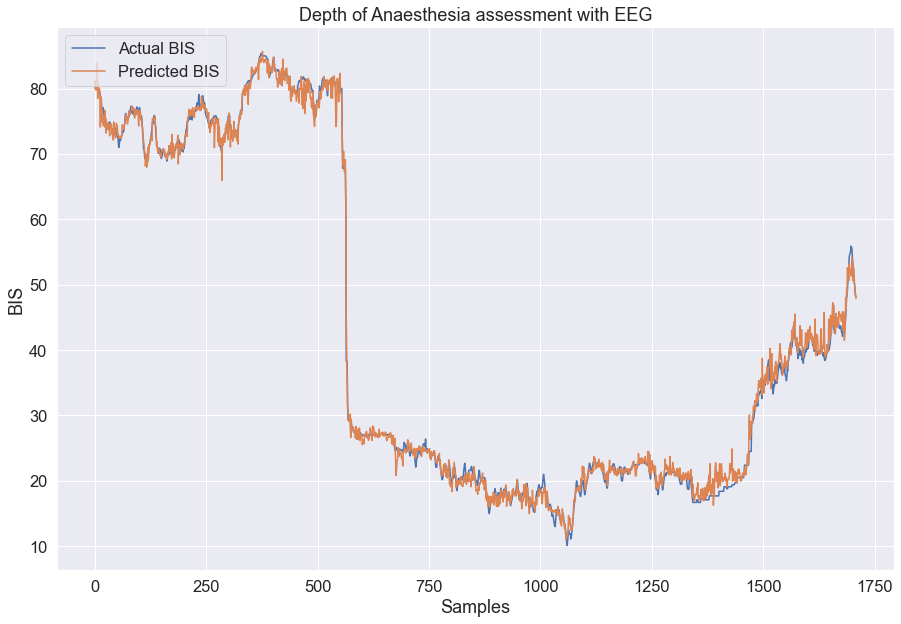

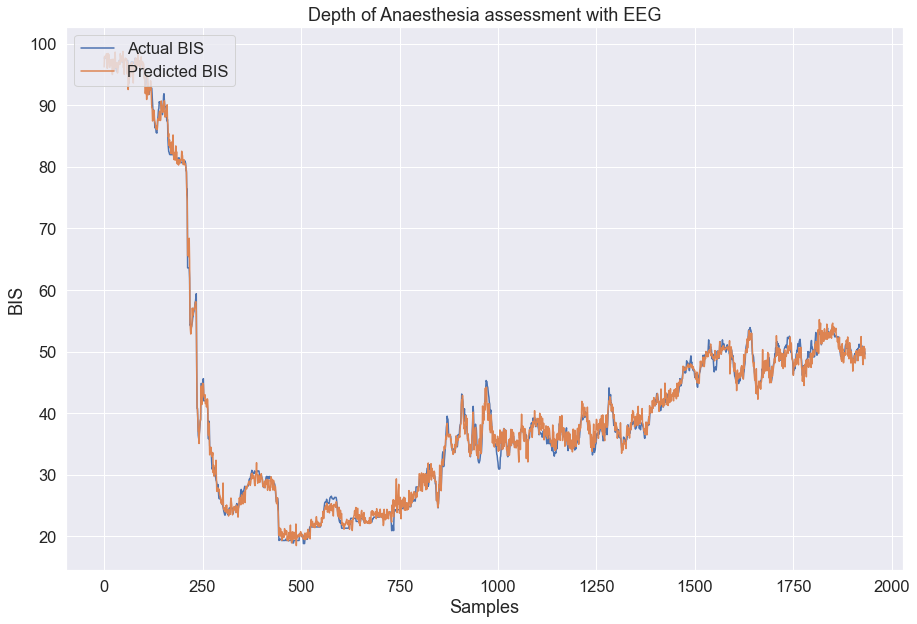

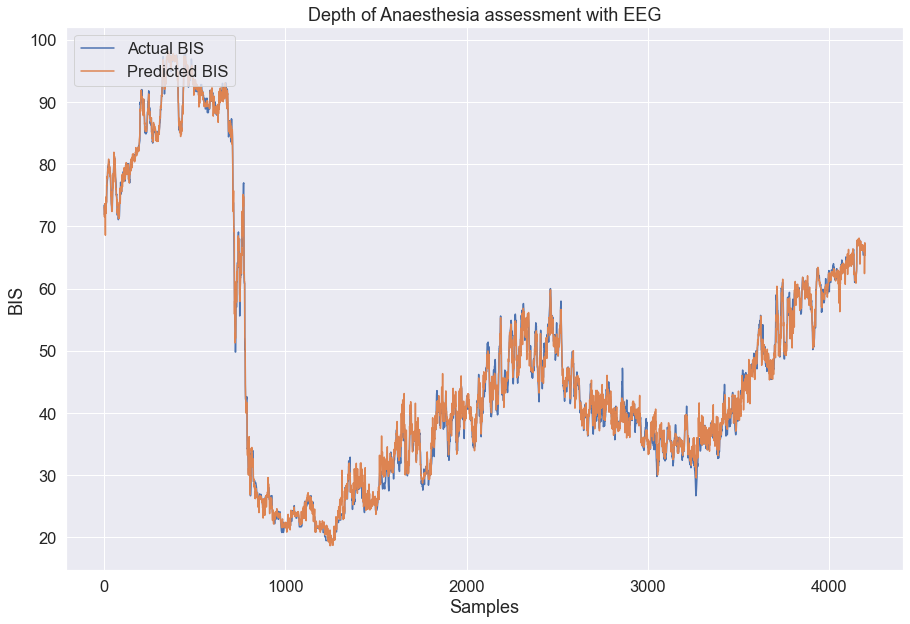

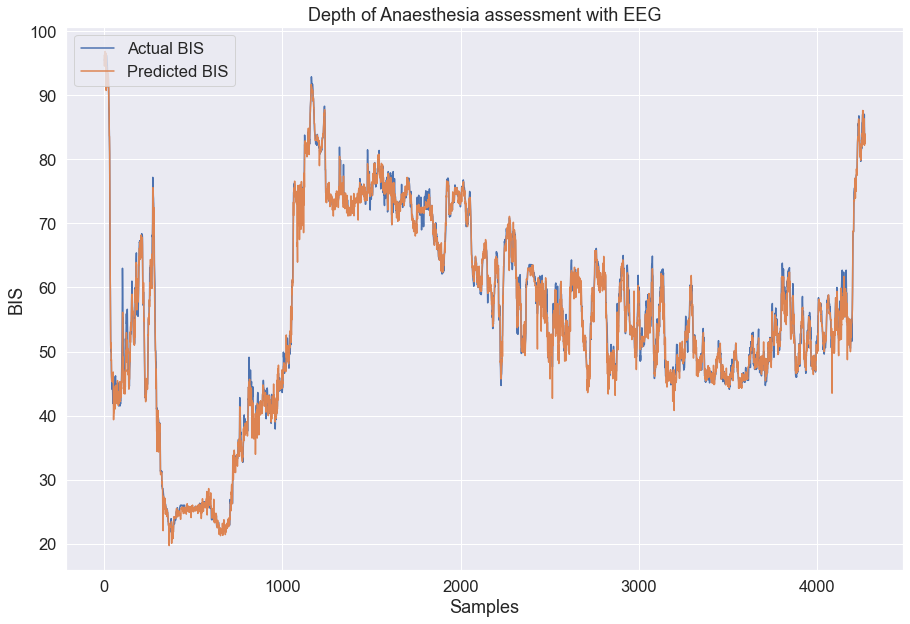

In [135]:
for train in training_set:
    patient = create_dataset(patient=train)
    xg_boost.predict(patient, selected_features, evaluate=False)

<br/>

<br/>

## <code>Histogram-based Gradient boosting tree (Experimental)</code>

In [129]:
hist = model('hist_r', training_df, scale=False)

# Train the model
hist.fit(selected_features)

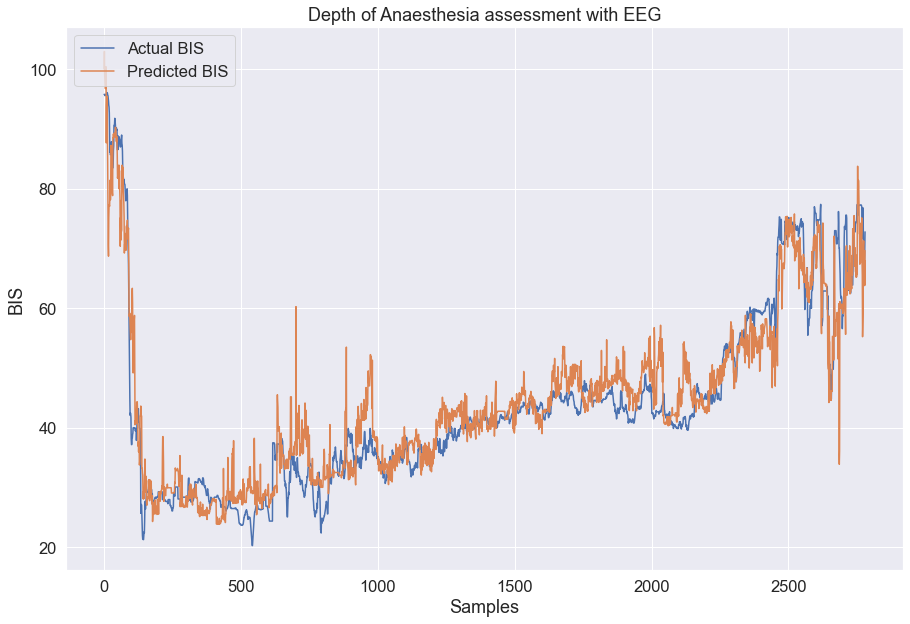

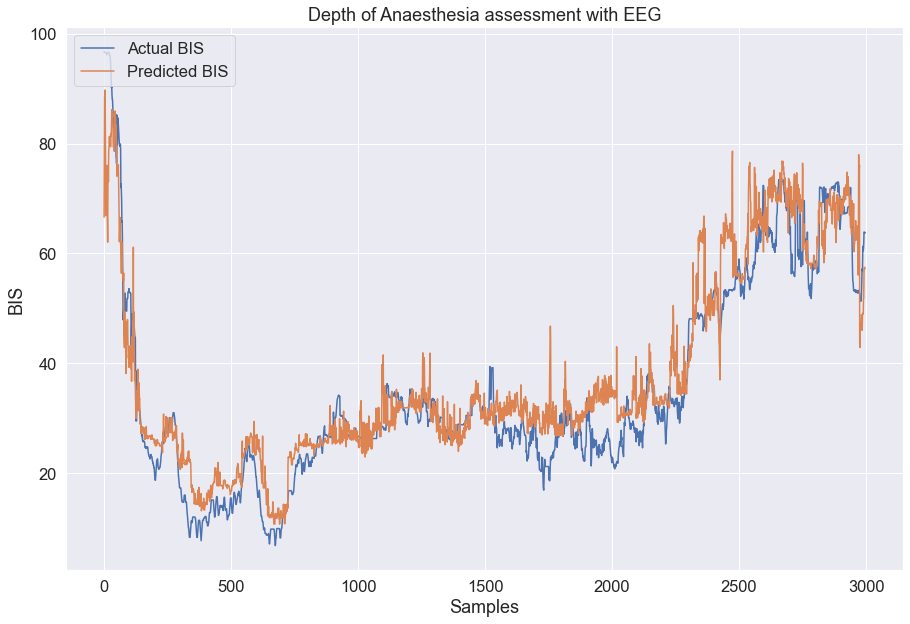

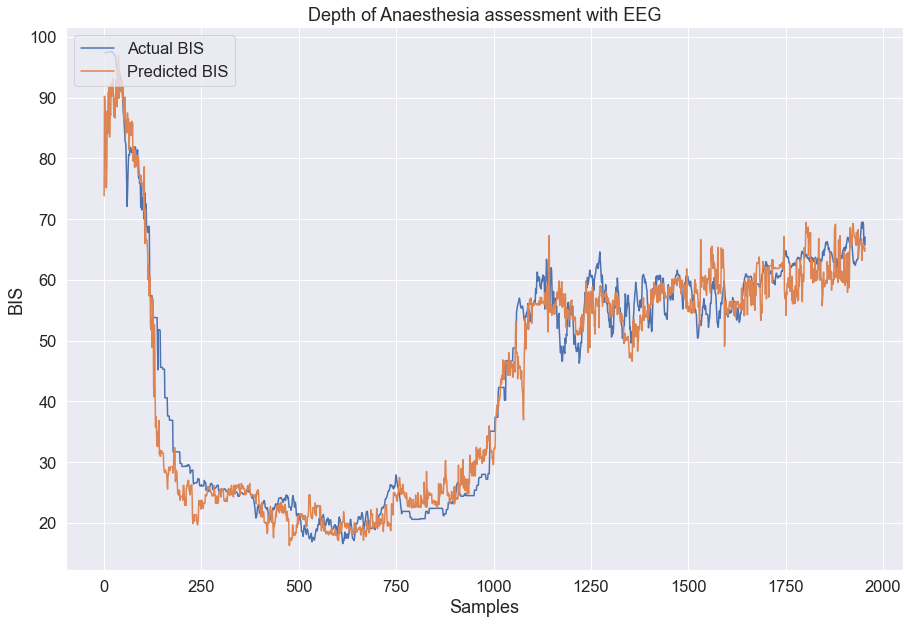

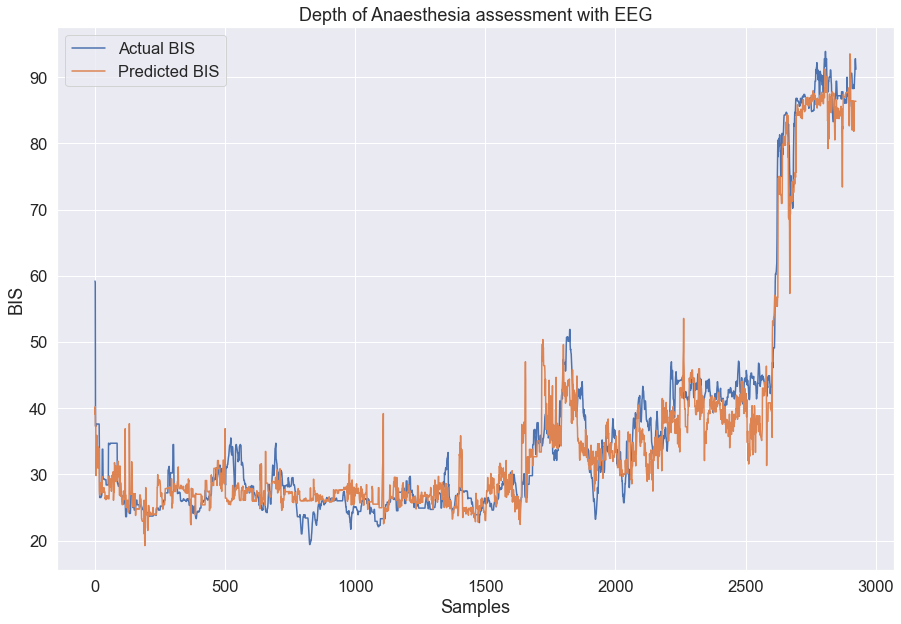

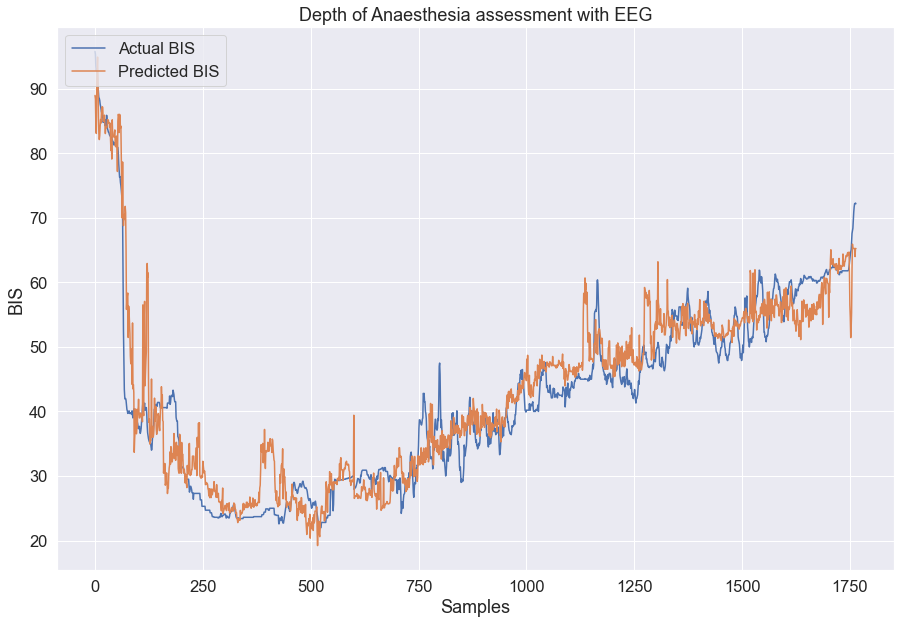

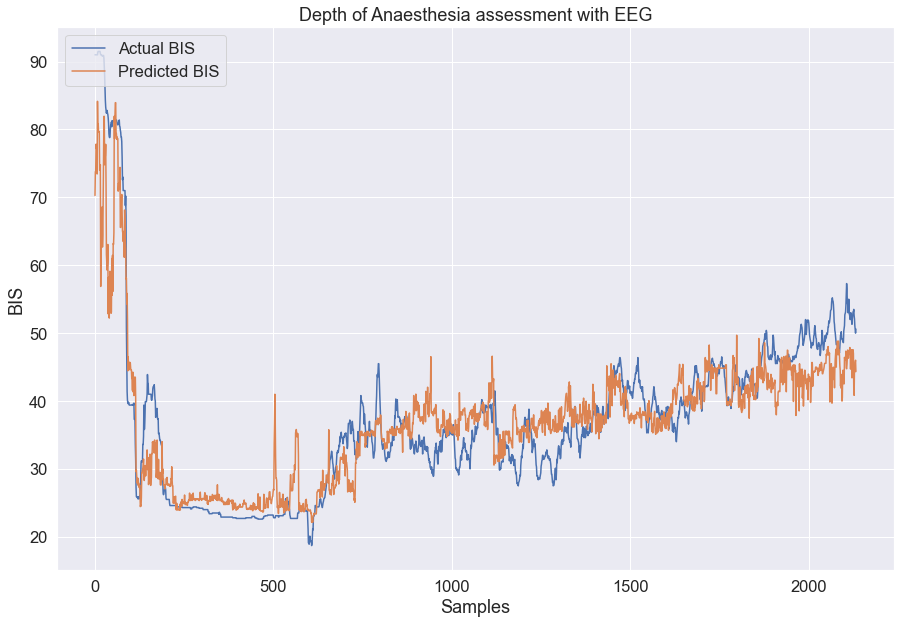

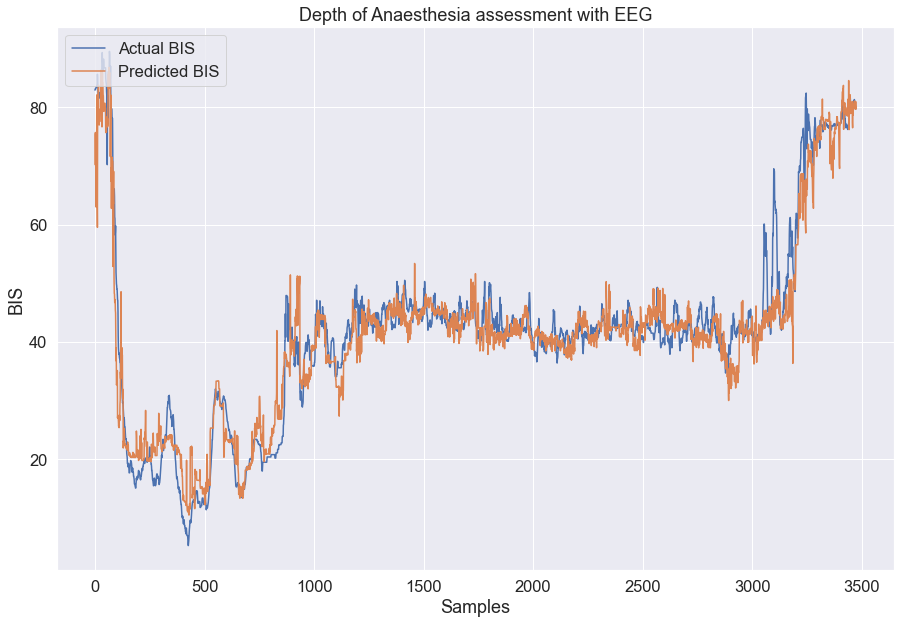

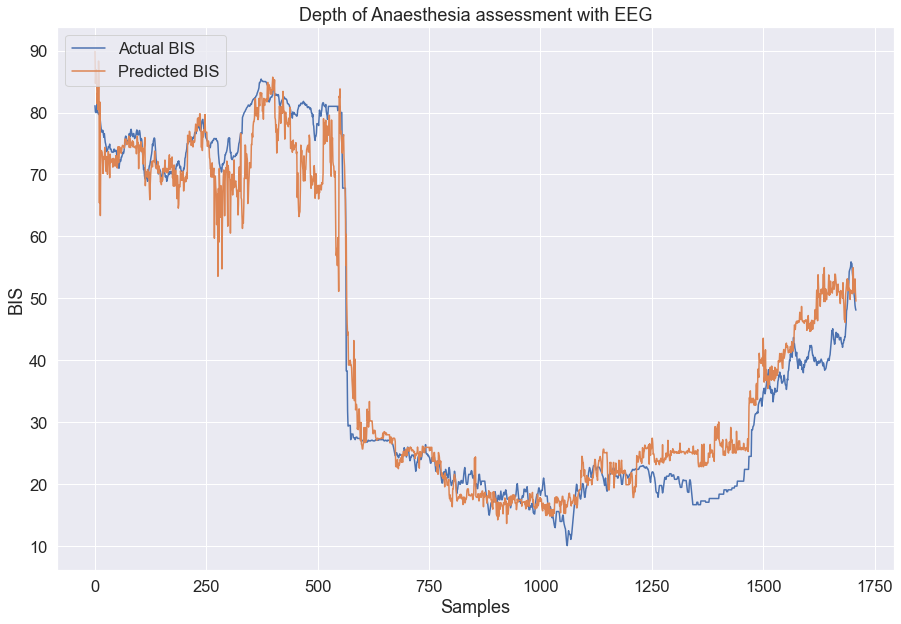

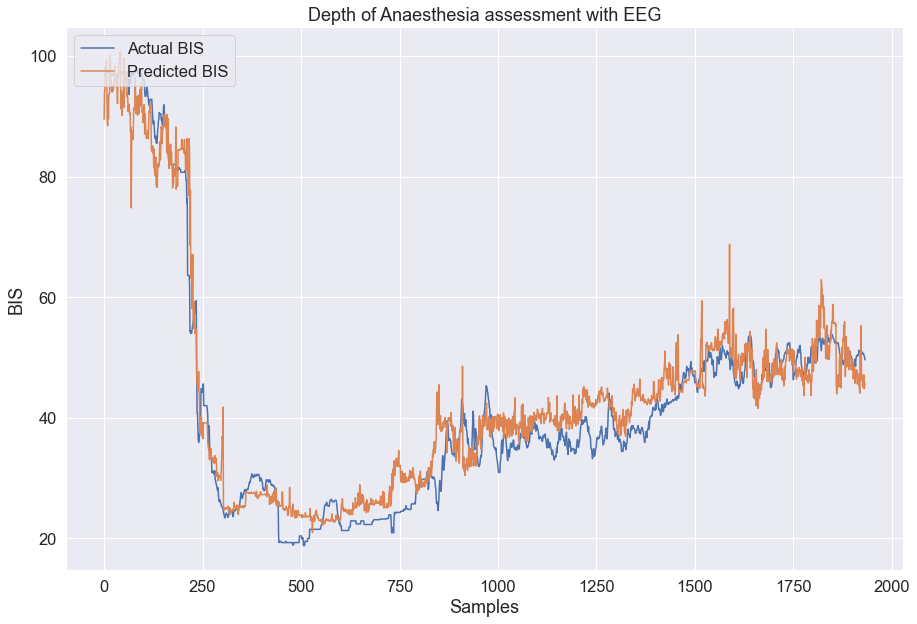

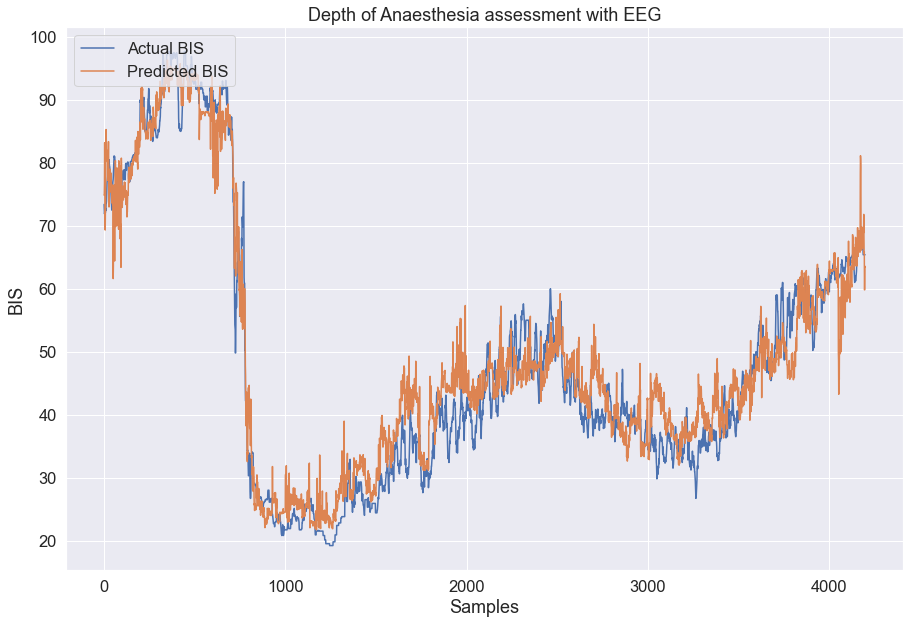

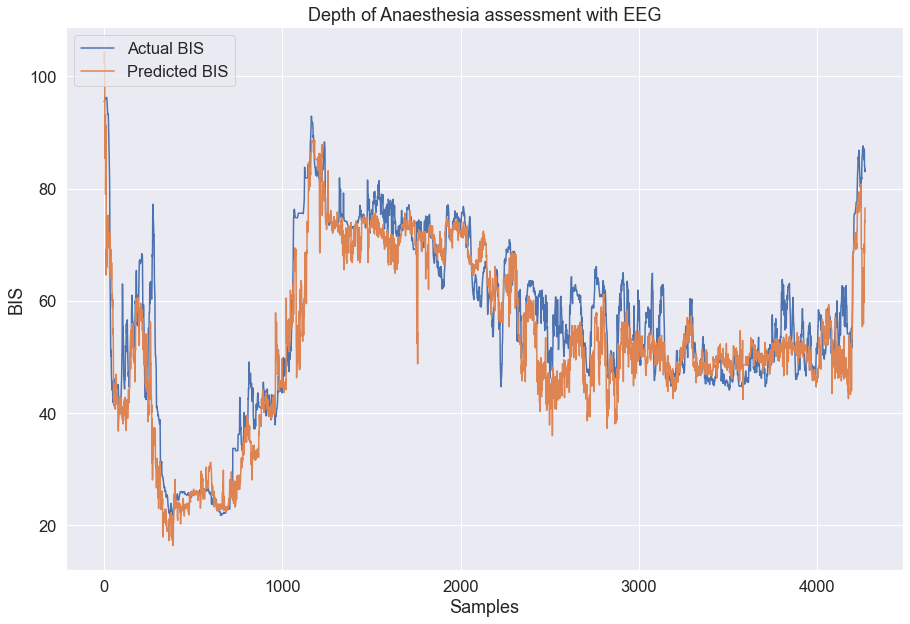

In [130]:
for train in training_set:
    patient = create_dataset(patient=train)
    hist.predict(patient, selected_features, evaluate=False)

<br/>

## Selected Model: <code>XG Boost Regression</code>

Xgboost is selected because it has a good training accuracy. This is not to say the model will perform best on the test set however, choosing a model with a good correlation with the BIS is a good place to start due to the time constraints of this project.

<br/>

## Model Selection: Part 2

### Hyperparameter Tuning

In [142]:
# Exploring the number of trees
def get_models():
    models = {}
    trees = [10, 50, 100, 500, 1000, 5000]
    
    for n in trees:
        models[str(n)] = XGBRegressor(n_estimators=n)
        
    return models

In [143]:
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    return scores

>10 0.855 (0.007)
>50 0.922 (0.005)
>100 0.938 (0.004)
>500 0.952 (0.003)
>1000 0.953 (0.003)
>5000 0.954 (0.003)


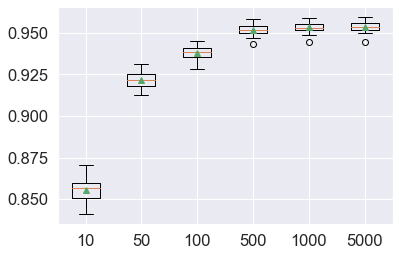

In [147]:
# define dataset
X, y = training_df[selected_features], training_df['BIS']

# get the models
models = get_models()

results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot model performance
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Coefficient of determination, R^2')
plt.xlabel('Number of estimators')
plt.show()

<br/>

In [151]:
# Exploring tree depth
def get_models():
    models = {}
    
    for i in range(1, 11):
        models[str(i)] = XGBRegressor(n_estimators=100, max_depth=i)
        
    return models

>1 0.697 (0.009)
>2 0.801 (0.007)
>3 0.860 (0.006)
>4 0.898 (0.005)
>5 0.922 (0.004)
>6 0.938 (0.004)
>7 0.947 (0.002)
>8 0.954 (0.002)
>9 0.956 (0.002)
>10 0.959 (0.003)


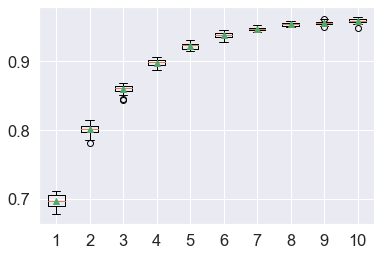

In [152]:
# define dataset
X, y = training_df[selected_features], training_df['BIS']

# get the models
models = get_models()

results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot model performance
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Coefficient of determination, R^2')
plt.xlabel('Tree depth')
plt.show()

<br/>

In [156]:
# Learning rate
def get_models():
    models = {}
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = XGBRegressor(n_estimators=100, max_depth=8, learning_rate=r)
        
    return models

>0.0001 -5.010 (0.121)
>0.0010 -4.053 (0.101)
>0.0100 0.052 (0.020)
>0.1000 0.945 (0.003)
>1.0000 0.910 (0.007)


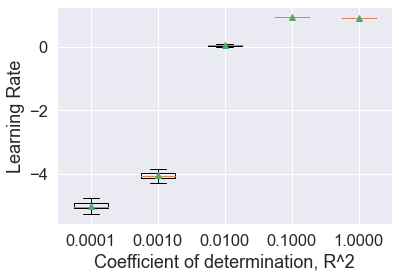

In [157]:
# define dataset
X, y = training_df[selected_features], training_df['BIS']

# get the models
models = get_models()

results, names = [], []

for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot model performance
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Coefficient of determination, R^2')
plt.xlabel('Learning Rate')
plt.show()

<br/>

In [159]:
# Final Model
xg_boost = XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.1)

In [160]:
# Select the best features
xg_boost.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<br/>

### Feature Importances

In [161]:
xg_boost.feature_importances_

array([0.02620552, 0.4594211 , 0.07604342, 0.0659237 , 0.1742265 ,
       0.13675812, 0.06142167], dtype=float32)

In [163]:
final_selected_features = ["SampenCD_2D", "SampenCA_4DS", "SampenCD_2DS"]

<br/>

In [165]:
# Final training
xg_boost.fit(X[final_selected_features], y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<br/>

<br/>

# Model Evaluation

In [ ]:
# To be continued...